In [ ]:
!cp -r /content/drive/MyDrive/dataset /content


In [ ]:
logging.basicConfig(level=logging.INFO)


Mounted at /content/drive
GPU is available and being used
Found 20620 images belonging to 2 classes.
Found 5154 images belonging to 2 classes.
Epoch 1/10
644/644 [==============================] - 469s 724ms/step - loss: 0.6770 - accuracy: 0.5836 - val_loss: 0.6936 - val_accuracy: 0.5233
Epoch 2/10
644/644 [==============================] - 384s 596ms/step - loss: 0.6566 - accuracy: 0.6113 - val_loss: 0.7196 - val_accuracy: 0.4884
Epoch 3/10
644/644 [==============================] - 382s 593ms/step - loss: 0.6524 - accuracy: 0.6176 - val_loss: 0.7360 - val_accuracy: 0.5087
Epoch 4/10
644/644 [==============================] - 383s 594ms/step - loss: 0.6476 - accuracy: 0.6245 - val_loss: 0.7215 - val_accuracy: 0.4823
Epoch 5/10
644/644 [==============================] - 435s 675ms/step - loss: 0.6429 - accuracy: 0.6287 - val_loss: 0.7290 - val_accuracy: 0.4897
Epoch 6/10
644/644 [==============================] - 381s 592ms/step - loss: 0.6395 - accuracy: 0.6295 - val_loss: 0.7413 - va

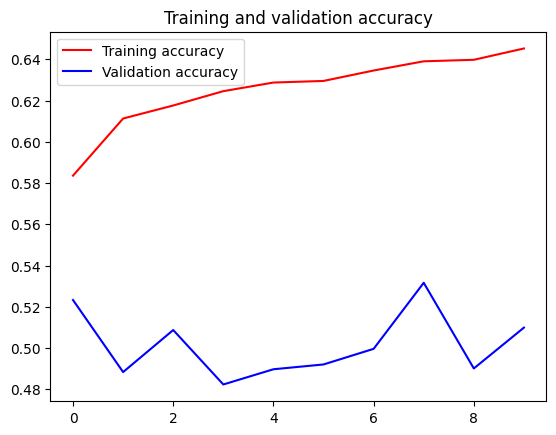

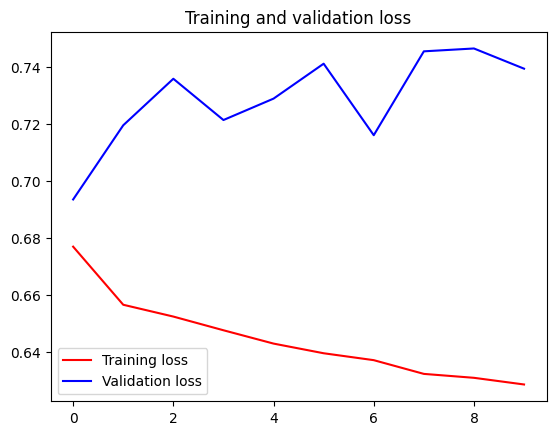

In [ ]:
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import logging

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Function to clean dataset directory
def clean_directory(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                logging.info(f'Removing invalid file: {file_path}')
                os.remove(file_path)

# Paths to your dataset directories
base_dir = '/content/drive/My Drive/dataset'
recyclable_dir = os.path.join(base_dir, 'recyclable')
non_recyclable_dir = os.path.join(base_dir, 'non_recyclable')

# Clean the dataset directories
clean_directory(recyclable_dir)
clean_directory(non_recyclable_dir)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used")
else:
    print("GPU is not available")

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split= 0.2 # Use 99% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,  # Increase batch size
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,  # Increase batch size
    class_mode='binary',
    subset='validation'
)

# Build the simplified Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Reduce the number of epochs for quicker runs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Plot the Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()


In [ ]:
model.save('/content/drive/My Drive/recyclable_non_recyclable_classifier.keras')


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/My Drive/recyclable_non_recyclable_classifier.keras')


In [ ]:
# check model

from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
loaded_model = load_model('/content/drive/My Drive/recyclable_non_recyclable_classifier.keras')

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to make predictions
def predict_image_class(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    return "Recyclable" if prediction[0][0] > 0.5 else "Non-Recyclable"

# Example usage:
img_path = '/content/drive/My Drive/butter.png'  # Update with your image path
prediction = predict_image_class(loaded_model, img_path)
print(f"The predicted class for the image is: {prediction}")


1/1 [==============================] - 0s 86ms/step
The predicted class for the image is: Recyclable


In [ ]:
import os

def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

recyclable_count = count_files('/content/drive/My Drive/dataset/recyclable')
non_recyclable_count = count_files('/content/drive/My Drive/dataset/non_recyclable')

print(f"Recyclable: {recyclable_count}, Non-Recyclable: {non_recyclable_count}")


Recyclable: 14986, Non-Recyclable: 3156


In [ ]:
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import logging

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Function to clean dataset directory
def clean_directory(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                logging.info(f'Removing invalid file: {file_path}')
                os.remove(file_path)

# Paths to your dataset directories
base_dir = '/content/drive/My Drive/dataset'
recyclable_dir = os.path.join(base_dir, 'recyclable')
non_recyclable_dir = os.path.join(base_dir, 'non_recyclable')

# Clean the dataset directories
clean_directory(recyclable_dir)
clean_directory(non_recyclable_dir)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used")
else:
    print("GPU is not available")

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Use VGG16 pretrained model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the Model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,  # Increase the number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Plot the Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


GPU is not available
Found 20620 images belonging to 2 classes.
Found 5154 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
 15/644 [..............................] - ETA: 1:38:16 - loss: 0.6957 - accuracy: 0.5938

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


644/644 [==============================] - 6554s 10s/step - loss: 0.5820 - accuracy: 0.6922 - val_loss: 0.7896 - val_accuracy: 0.5328 - lr: 1.0000e-04
Epoch 2/20
644/644 [==============================] - 6564s 10s/step - loss: 0.5345 - accuracy: 0.7298 - val_loss: 0.8040 - val_accuracy: 0.5365 - lr: 1.0000e-04
Epoch 3/20
644/644 [==============================] - 6637s 10s/step - loss: 0.5098 - accuracy: 0.7460 - val_loss: 0.8125 - val_accuracy: 0.5557 - lr: 1.0000e-04
Epoch 4/20
644/644 [==============================] - 6604s 10s/step - loss: 0.5028 - accuracy: 0.7480 - val_loss: 0.8029 - val_accuracy: 0.5592 - lr: 1.0000e-04
Epoch 5/20
644/644 [==============================] - 6547s 10s/step - loss: 0.4739 - accuracy: 0.7689 - val_loss: 0.7588 - val_accuracy: 0.5868 - lr: 2.0000e-05
Epoch 6/20
644/644 [==============================] - 6547s 10s/step - loss: 0.4664 - accuracy: 0.7748 - val_loss: 0.7701 - val_accuracy: 0.5730 - lr: 2.0000e-05
Epoch 7/20
357/644 [===============>...

Mounted at /content/drive
GPU is available and being used
Found 20620 images belonging to 2 classes.
Found 5154 images belonging to 2 classes.
No checkpoint found, starting training from scratch.
Epoch 1/20
323/323 [==============================] - 382s 1s/step - loss: 0.6285 - accuracy: 0.6569 - val_loss: 0.7948 - val_accuracy: 0.4967 - lr: 1.0000e-04
Epoch 2/20
323/323 [==============================] - 379s 1s/step - loss: 0.5629 - accuracy: 0.7100 - val_loss: 0.7972 - val_accuracy: 0.5105 - lr: 1.0000e-04
Epoch 3/20
323/323 [==============================] - 378s 1s/step - loss: 0.5424 - accuracy: 0.7240 - val_loss: 0.8097 - val_accuracy: 0.5179 - lr: 1.0000e-04
Epoch 4/20
323/323 [==============================] - 377s 1s/step - loss: 0.5252 - accuracy: 0.7346 - val_loss: 0.7841 - val_accuracy: 0.5446 - lr: 1.0000e-04
Epoch 5/20
323/323 [==============================] - 377s 1s/step - loss: 0.5097 - accuracy: 0.7436 - val_loss: 0.8002 - val_accuracy: 0.5448 - lr: 1.0000e-04
Epoc

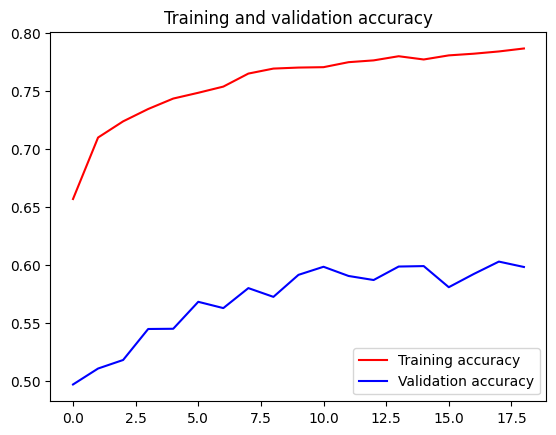

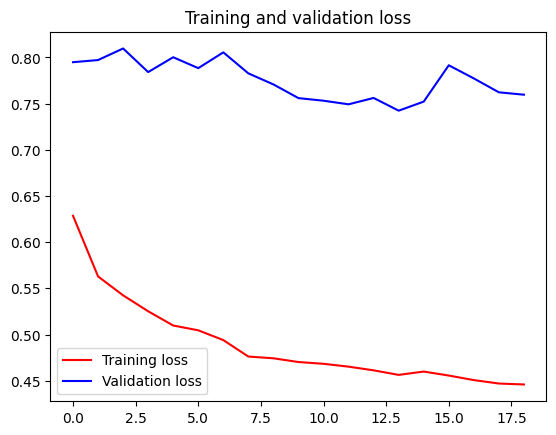

In [ ]:
# newest version

import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import logging

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Function to clean dataset directory
def clean_directory(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                logging.info(f'Removing invalid file: {file_path}')
                os.remove(file_path)

# Paths to your dataset directories
base_dir = '/content/drive/My Drive/dataset'
checkpoint_dir = '/content/drive/My Drive/checkpoints'

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Clean the dataset directories
clean_directory(base_dir)

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used")
else:
    print("GPU is not available")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Image Data Generators with more aggressive augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=64,  # Increased batch size
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=64,  # Increased batch size
    class_mode='binary',
    subset='validation'
)

# Use VGG16 pretrained model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the Model with additional layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Ensure the output layer uses float32
])

# Compile the Model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# Checkpoint callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),
    save_weights_only=True,
    save_freq='epoch'
)

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Load the latest checkpoint if it exists
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print(f"Loaded weights from checkpoint: {latest_checkpoint}")
else:
    print("No checkpoint found, starting training from scratch.")

# Train the Model
history = model.fit(
    train_generator,
    epochs=20,  # Start with a high number of epochs
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint_callback]
)

# Plot the Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()


In [ ]:
pip install pillow pyheif


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 31.4 MB/s eta 0:00:00


In [ ]:
model.save('/content/drive/My Drive/recyclable_non_recyclable_classifier.keras')

In [ ]:
import os

def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

recyclable_count = count_files('/content/drive/My Drive/dataset/recyclable')
non_recyclable_count = count_files('/content/drive/My Drive/dataset/non_recyclable')

print(f"Recyclable: {recyclable_count}, Non-Recyclable: {non_recyclable_count}")


Recyclable: 14986, Non-Recyclable: 10830


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Load the saved model
loaded_model = load_model('/content/drive/My Drive/recyclable_non_recyclable_classifier.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image
import pyheif

# Function to convert image to PNG if necessary
def convert_to_png(img_path):
    if img_path.lower().endswith('.heic'):
        heif_file = pyheif.read(img_path)
        img = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
        img = img.convert("RGB")
    else:
        img = Image.open(img_path)

    if not img_path.lower().endswith('.png'):
        png_path = img_path.rsplit('.', 1)[0] + '.png'
        img.save(png_path, 'PNG')
        return png_path
    return img_path

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to make predictions
def predict_image_class(model, img_path):
    img_path = convert_to_png(img_path)
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    return "Recyclable" if prediction[0][0] > 0.5 else "Non-Recyclable"

# Example usage:
img_path = '/content/drive/My Drive/IMG_4499.HEIC'  # Update with your image path
loaded_model = load_model('/content/drive/My Drive/recyclable_non_recyclable_classifier.keras')  # Load your trained model
prediction = predict_image_class(loaded_model, img_path)
print(f"The predicted class for the image is: {prediction}")


1/1 [==============================] - 0s 268ms/step
The predicted class for the image is: Non-Recyclable
